# Image Segmentation

### 다음과 같은 일반적인 workflow로 진행
1. Visualize data/perform some exploratory data analysis
2. Set up data pipeline and preprocessing
3. Build model
4. Train model
5. Evaluate model
6. Repeat

## Project 설명

### Task
* GIANA dataset으로 위내시경 이미지에서 용종을 segmentation 해보자.
* 데이터 불러오기를 제외한 딥러닝 트레이닝 과정을 직접 구현해보는 것이 목표 입니다.
* This code is borrowed from [TensorFlow tutorials/Image Segmentation](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) which is made of `tf.keras.layers`.
* You can see the detail description [tutorial link](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb)  

### Dataset
* I use below dataset instead of [carvana-image-masking-challenge dataset](https://www.kaggle.com/c/carvana-image-masking-challenge/rules) in TensorFlow Tutorials which is a kaggle competition dataset.
  * carvana-image-masking-challenge dataset: Too large dataset (14GB)
* [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (345MB)
  * Train data: 300 images with RGB channels (bmp format)
  * Train lables: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500
* Training시 **image size는 256**으로 resize

### Baseline code
* Dataset: train, test로 split
* Input data shape: (`batch_size`, 256, 256, 3)
* Output data shape: (`batch_size`, 256, 256, 1)
* Architecture: 
  * 간단한 Encoder-Decoder 구조
  * U-Net 구조
  * [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 사용
* Training
  * `tf.data.Dataset` 사용
  * `model.fit()` 사용 for weight update
* Evaluation
  * MeanIOU: Image Segmentation에서 많이 쓰이는 evaluation measure
  * tf.version 2.0 API: [`tf.keras.metrics.MeanIoU`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics/MeanIoU)

### Try some techniques
* Change model architectures (Custom model)
  * Try another models (Unet 모델)
* Various regularization methods

## Import modules

### Import colab modules for Google Colab (if necessary)

In [0]:
!pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8MB 28kB/s 
     |████████████████████████████████| 3.9MB 52.2MB/s 
     |████████████████████████████████| 450kB 49.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=57d9b2bc2f7dc9f0d7205dd31feacd72849feaa01bab61d626a6fe780d8874ad
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tens

In [0]:
use_colab = True
assert use_colab in [True, False]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import base modules

In [24]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
print(tf.__version__)

from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU

2.2.0


# 사용 모델 선택
* 학습 및 inference에서 사용할 모델 선택

In [0]:
is_train = True

model_name = 'u-net'
assert model_name in ['ed_model', 'u-net']

## 데이터 수집 및 Visualize

### Download data

이 프로젝트는 [Giana Dataset](https://giana.grand-challenge.org/Dates/)을 이용하여 진행한다.

In [5]:
# Unfortunately you cannot downlaod GIANA dataset from website
# So I upload zip file on my dropbox
# if you want to download from my dropbox uncomment below  
if use_colab:
    DATASET_PATH='./drive/My Drive/datasets/sd_train'
else:
    DATASET_PATH='../../datasets/sd_train'

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

    import urllib.request
    u = urllib.request.urlopen(url='http://bigfile.mail.naver.com/bigfileupload/download?fid=8sbZaAIq1NK/KoujK3YXFoMrKxvjKogZKAg9KxtwKotdKAUjKxElKogrKAKla3Y9KxtlFoEdaAMXpAbdMxtXFqtdFxuZF6EZM6JSKoumag==')
    data = u.read()
    u.close()

    with open('sd_train.zip', "wb") as f :
        f.write(data)
        print('Data has been downloaded')

    shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
    file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

    import zipfile
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(DATASET_PATH)
    zip_ref.close()
    print('Data has been extracted.')
    
else:
    print('Data has already been downloaded and extracted.')

Data has already been downloaded and extracted.


### Split dataset into train data and test data

In [0]:
dataset_dir = os.path.join(DATASET_PATH, 'sd_train')

img_dir = os.path.join(dataset_dir, "train")
label_dir = os.path.join(dataset_dir, "train_labels")

In [0]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [0]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=219)

In [9]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### Visualize

데이터 셋에서 5장 (`display_num`)의 이미지를 살펴보자.

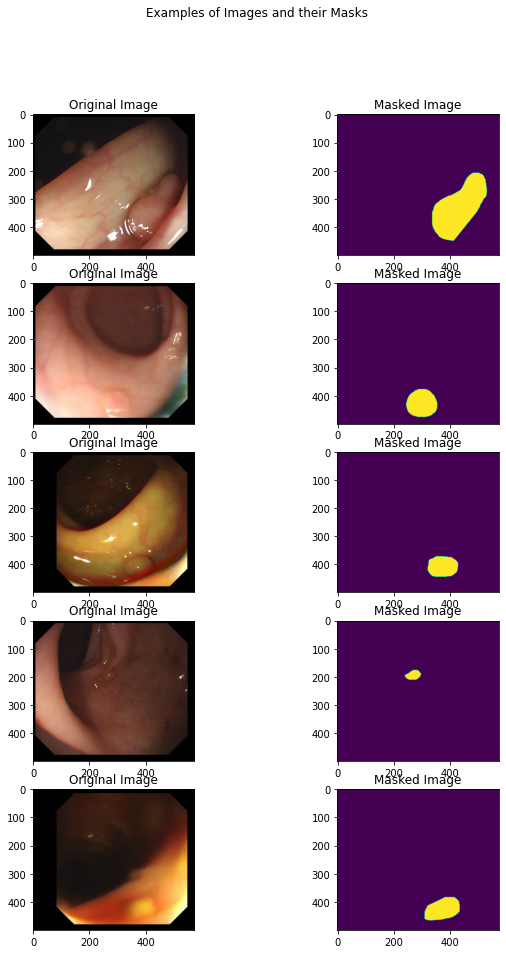

In [10]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

## Data pipeline and preprocessing 만들기

### Set up hyper-parameters

Hyper-parameter를 셋팅해보자. 이미지 사이즈, 배치 사이즈 등 training parameter들을 셋팅해보자.

In [0]:
# Set hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 50
print_steps = 100
save_epochs = 5

if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/segmentation/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'train/segmentation/exp1'

### Build our input pipeline with `tf.data`

Input data pipeline을 만들기 가장 좋은 방법은 [**tf.data**](https://www.tensorflow.org/guide/datasets) (링크 참조) 를 사용하는 것이다. `tf.data` API 를 잘 읽어보자.


#### Our input pipeline will consist of the following steps:

TensorFlow segmentation tutorial input pipeline 참고 하였음.


>1. Read the bytes of the file in from the filename - for both the image and the label. Recall that our labels are actually images with each pixel annotated as car or background (1, 0). 
>2. Decode the bytes into an image format
>3. Apply image transformations: (optional, according to input parameters)
>  * `resize` - Resize our images to a standard size (as determined by eda or computation/memory restrictions)
>    * The reason why this is optional is that U-Net is a fully convolutional network (e.g. with no fully connected units) and is thus not dependent on the input size. However, if you choose to not resize the images, you must use a batch size of 1, since you cannot batch variable image size together
>    * Alternatively, you could also bucket your images together and resize them per mini-batch to avoid resizing images as much, as resizing may affect your performance through interpolation, etc.
>  * `hue_delta` - Adjusts the hue of an RGB image by a random factor. This is only applied to the actual image (not our label image). The `hue_delta` must be in the interval `[0, 0.5]` 
>  * `horizontal_flip` - flip the image horizontally along the central axis with a 0.5 probability. This transformation must be applied to both the label and the actual image. 
>  * `width_shift_range` and `height_shift_range` are ranges (as a fraction of total width or height) within which to randomly translate the image either horizontally or vertically. This transformation must be applied to both the label and the actual image. 
>  * `rescale` - rescale the image by a certain factor, e.g. 1/ 255.
>4. Shuffle the data, repeat the data (so we can iterate over it multiple times across epochs), batch the data, then prefetch a batch (for efficiency).

#### Why do we do these image transformations?

Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉이다. 자세한 내용은 아래 TensorFlow 공식 예제 링크로 대체한다.

> This is known as **data augmentation**. Data augmentation "increases" the amount of training data by augmenting them via a number of random transformations. During training time, our model would never see twice the exact same picture. This helps prevent [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) and helps the model generalize better to unseen data.

#### Processing each pathname

In [0]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### Shifting the image

In [0]:
import tensorflow_addons as tfa

def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random_uniform([], 
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random_uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
          # Translate both 
        #output_img = tfcontrib.image.translate(output_img,
        #                                         [width_shift_range, height_shift_range])
        #label_img = tfcontrib.image.translate(label_img,
        #                                         [width_shift_range, height_shift_range])
    

        # 버전 1에서 사용하던 tfcontrib 이 아닌 tfa로 변경하여 사용 
        # OpenCV 로 해도 된다. 가장 많이 사용하는 방법

        output_img = tfa.image.translate(output_img,[width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,[width_shift_range, height_shift_range])
    return output_img, label_img

#### Flipping the image randomly

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

#### Assembling our transformations into our augment function

In [0]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [0]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

### Set up train and test datasets
Note that we apply image augmentation to our training dataset but not our validation dataset.

In [0]:
train_dataset = get_baseline_dataset(x_train_filenames,
                                     y_train_filenames)
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)

In [18]:
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

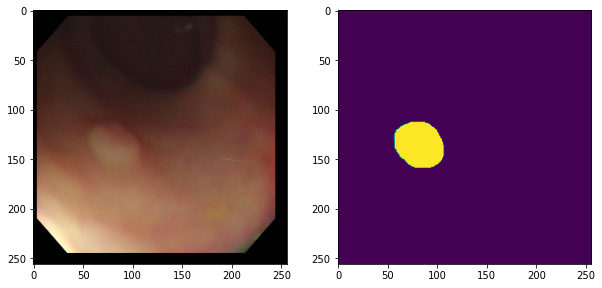

In [19]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## Build the model

해당 프로젝트는 두 개의 네트워크를 만들어보는 것이 목표이다.
* Encoder-Decoder 스타일의 네트워크
* [U-Net](https://arxiv.org/abs/1505.04597)

### Encoder-Decoder architecture

#### Encoder
* 다음과 같은 구조로 Encoder로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = [batch_size, 256, 256, 3]
  * conv1 = [batch_size, 128, 128, 32]
  * conv2 = [batch_size, 64, 64, 64]
  * conv3 = [batch_size, 32, 32, 128]
  * outputs = [batch_size, 16, 16, 256]
* Convolution - Normalization - Activation 등의 조합을 다양하게 생각해보자.
* Pooling을 쓸지 Convolution with stride=2 로 할지 잘 생각해보자.
* `tf.keras.Sequential()`을 이용하여 만들어보자.
  
#### Decoder
* Encoder의 mirror 형태로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = encoder의 outputs = [batch_size, 16, 16, 256]

- conv_transpose 는 conv가 이미지를 축소하는 역할을 하였다면 이건 늘려주는 역할을 한다
  * conv_transpose1 = [batch_size, 32, 32, 128]
  * conv_transpose2 = [batch_size, 64, 64, 64]
  * conv_transpose3 = [batch_size, 128, 128, 32]
  * outputs = [batch_size, 256, 256, 1]
* `tf.keras.Sequential()`을 이용하여 만들어보자.

In [0]:
if model_name == 'ed_model':
    encoder = tf.keras.Sequential(name='encoder')

In [0]:
if model_name == 'ed_model':
    # inputs: [batch_size, 256, 256, 3]
    # conv-batchnorm-activation-maxpool
  encoder.add(layers.Conv2D(32, (3, 3), padding='same'))
  encoder.add(layers.BatchNormalization())
  encoder.add(layers.Activation('relu'))
  encoder.add(layers.MaxPool2D()) # conv1: [batch_size, 128, 128, 32]

  encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
  encoder.add(layers.BatchNormalization())
  encoder.add(layers.Activation('relu'))
  encoder.add(layers.MaxPool2D()) # conv2: [batch_size, 64, 64, 64]

  encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
  encoder.add(layers.BatchNormalization())
  encoder.add(layers.Activation('relu'))
  encoder.add(layers.MaxPool2D()) # outputs: [batch_size, 32, 32, 128]

  encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
  encoder.add(layers.BatchNormalization())
  encoder.add(layers.Activation('relu'))
  encoder.add(layers.MaxPool2D()) # outputs: [batch_size, 16, 16, 256]

In [0]:
# encoder 제대로 만들어졌는지 확인
if model_name == 'ed_model':
    bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
    print(bottleneck.shape)

(8, 16, 16, 256)


In [0]:
if model_name == 'ed_model':
    decoder = tf.keras.Sequential(name='decoder')

In [0]:
if model_name == 'ed_model':
    # inputs: [batch_size, 16, 16, 256]
    # conv_transpose-batchnorm-activation
  decoder.add(layers.Conv2DTranspose(128, (2, 2), strides=2, padding='same'))
  decoder.add(layers.BatchNormalization())
  decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 128]

  decoder.add(layers.Conv2DTranspose(64, (2, 2), strides=2, padding='same'))
  decoder.add(layers.BatchNormalization())
  decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 64]

  decoder.add(layers.Conv2DTranspose(128, (2, 2), strides=2, padding='same'))
  decoder.add(layers.BatchNormalization())
  decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 32]

  decoder.add(layers.Conv2DTranspose(1, (2, 2), strides=2, padding='same'))
  decoder.add(layers.BatchNormalization())
  decoder.add(layers.Activation('sigmoid')) # outputs: [batch_size, 256, 256, 1]

In [0]:
# decoder 제대로 만들어졌는지 확인
if model_name == 'ed_model':
    predictions = decoder(bottleneck)
    print(predictions.shape)

(8, 256, 256, 1)


#### Create a encoder-decocer model

In [0]:
if model_name == 'ed_model':
    ed_model = tf.keras.Sequential()
    ed_model.add(encoder)
    ed_model.add(decoder)

### U-Net architecture

<img src='https://user-images.githubusercontent.com/11681225/58005153-fd934300-7b1f-11e9-9ad8-a0e9186e751c.png' width="800">

아래는 U-Net 만들 때 참고하면 좋은 TensorFlow tutorial 설명이다.

>We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks. 

>The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale. 

#### The `tf.keras` Functional API

U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않는다. 이럴때는 `tf.keras.Sequential()`을 쓸 수가 없다. Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 `tf.keras` functional API 이다. 자세한 설명은 다음 [문서](https://keras.io/getting-started/functional-api-guide/)를 참고 하면 좋다.

In [0]:
if model_name == 'u-net':
    class Conv(tf.keras.Model):
        def __init__(self, num_filters, kernel_size):
            super(Conv, self).__init__()
            # conv-batchnorm-activation
            self.conv_1 = Conv2D(num_filters, kernel_size, padding='same') 
            self.bn_1 = BatchNormalization()
            
             # batchnorm
            # 재료준비 conv, bn, max 선언을 하고 쓸준비를 한다.

        def call(self, inputs, training=True):
            
            # x = self.conv(inputs)
            # y = self.bn(x)
            # z = layers.ReLU(y)

            x = self.conv_1(inputs)
            x = self.bn_1(x, training=training)
            x = layers.ReLU()(x)

            return x
            
#conv = Conv() 클래스가 call이 되면 call 함수가 호출된다.
#y,z = conv.call()

In [0]:
if model_name == 'u-net':
    class ConvBlock(tf.keras.Model):
        def __init__(self, num_filters):
            #conv filter size x and x * 2
            super(ConvBlock, self).__init__()
            self.conv1 = Conv(num_filters, 3) # conv x
            self.conv2 = Conv(num_filters * 2, 3) # conv x * 2

        def call(self, inputs, training=True):
            encoder = self.conv1(inputs) # conv input
            encoder = self.conv2(encoder) # conv encoder

            return encoder
    
    # 위에껀 fillter수를 곱하는 경우, 아래는 나누는경우 그렇기 때문에 두개를 나눠둠 하나만 쓸꺼면 상관없음
    class ConvBlock_R(tf.keras.Model):
        def __init__(self, num_filters):
            #conv filter size x and x / 2
            super(ConvBlock_R, self).__init__()
            self.conv1 = Conv(num_filters, 3) # conv x
            self.conv2 = Conv(num_filters // 2, 3) # conv x / 2

        def call(self, inputs, training=True):
            decoder = self.conv1(inputs) # conv input
            decoder = self.conv2(decoder) # conv decoder

            return decoder


# Block 단 설계를 잘 해야한다.

    class EncoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(EncoderBlock, self).__init__()
            self.conv_block = ConvBlock(num_filters)
            self.encoder_pool = layers.MaxPool2D()  # maxpool

        def call(self, inputs, training=True):
            encoder = self.conv_block(inputs)  #conv_block
            encoder_pool = self.encoder_pool(encoder) #encoder

            return encoder_pool, encoder


    class DecoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(DecoderBlock, self).__init__()
            self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same') #conv transpose
            self.bn = layers.BatchNormalization() #batchnorm
            self.conv_block_R = ConvBlock_R(num_filters) #convblock_R

        def call(self, input_tensor, concat_tensor, training=True):
            
            decoder = self.convT(input_tensor) # convT
            decoder = tf.concat([decoder, concat_tensor],-1) # concat tf.contcat([decoder, concat_tensor])
            decoder = self.bn(decoder) # 
            decoder = layers.ReLU()(decoder)# activation
            decoder = self.conv_block_R(decoder) # conv_block_R

            return decoder

In [0]:
if model_name == 'u-net':
    class UNet(tf.keras.Model):
        def __init__(self):
            super(UNet, self).__init__()
            self.encoder_block1 = EncoderBlock(32) #32
            self.encoder_block2 = EncoderBlock(64)  #64
            self.encoder_block3 = EncoderBlock(128)  #128
            self.encoder_block4 = EncoderBlock(256)  #256

            self.center = ConvBlock(512)

            self.decoder_block4 = DecoderBlock(256) #256
            self.decoder_block3 = DecoderBlock(128) #128
            self.decoder_block2 = DecoderBlock(64) #64
            self.decoder_block1 = DecoderBlock(32) #32

            self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

        def call(self, inputs, training=True):
            
            encoder1_pool, encoder1 = self.encoder_block1(inputs) #inputs
            encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) #encoder1_pool
            encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) #encoder2_pool
            encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) #encoder3_pool

            center = self.center(encoder4_pool)

            decoder4 = self.decoder_block4(center, encoder4)  #center, encoder4
            decoder3 = self.decoder_block3(decoder4, encoder3) #decoder4, encoder3
            decoder2 = self.decoder_block2(decoder3, encoder2) #decoder3, encoder2
            decoder1 = self.decoder_block1(decoder2, encoder1) #decoder2, encoder1

            outputs = self.output_conv(decoder1)

            return outputs

#### Create a U-Net model

In [0]:
if model_name == 'u-net':
    unet_model = UNet()

### Defining custom metrics and loss functions

우리가 사용할 loss function은 다음과 같다.
* binary cross entropy
* dice_loss

우리가 기존에 사용하던 loss외에 dice_loss를 추가해서 사용 추가한다는게 무엇일까?

[논문](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf)에 나온 Dice coefficient 수식

$$D = \frac{2 \sum_{i}^{N} p_{i}g_{i}}{\sum_{i}^{N} p_{i}^{2} + \sum_{i}^{N} g_{i}^{2}}$$

하지만 구현은 이렇게 할 것임.

$$D = \frac{2 \sum_{i}^{N} p_{i}g_{i} + \varepsilon}{\sum_{i}^{N} p_{i} +  \sum_{i}^{N} g_{i} + \varepsilon}$$

Dice loss의 자세한 설명은 아래를 참고하자.

>Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example.

>Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced.

>We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly.

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [0]:
optimizer = tf.keras.optimizers.Adam()

### Select a model

In [33]:
if model_name == 'ed_model':
    print('select the Encoder-Decoder model')
    model = ed_model

if model_name == 'u-net':
    print('select the U-Net model')
    model = unet_model

select the U-Net model


### Compile

In [34]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, 256, 256, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [35]:
model.summary()

Model: "u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block_1 (EncoderBloc multiple                  19776     
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  111552    
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_4 (EncoderBloc multiple                  1773312   
_________________________________________________________________
conv_block_5 (ConvBlock)     multiple                  7085568   
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  4428928   
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  6661

### Checkpoints (Object-based saving)

In [0]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
if is_train:
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                   model=model)
else:
    checkpoint = tf.train.Checkpoint(model=model)

## Train your model

In [0]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

### Training - `model.fit()` 함수 이용

In [38]:
history = model.fit(train_dataset, 
                    epochs=max_epochs,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    steps_per_epoch=num_train_examples//batch_size)

Epoch 1/50
30/30 [==============================] - 28s 948ms/step - loss: 1.2416 - dice_loss: 0.8801 - val_loss: 1.4980 - val_dice_loss: 0.8994
Epoch 2/50
30/30 [==============================] - 17s 582ms/step - loss: 1.1281 - dice_loss: 0.8688 - val_loss: 3.2804 - val_dice_loss: 0.8817
Epoch 3/50
30/30 [==============================] - 17s 582ms/step - loss: 1.0567 - dice_loss: 0.8150 - val_loss: 268.3593 - val_dice_loss: 0.8993
Epoch 4/50
30/30 [==============================] - 17s 581ms/step - loss: 0.9078 - dice_loss: 0.7165 - val_loss: 542.3282 - val_dice_loss: 0.8978
Epoch 5/50
30/30 [==============================] - 17s 580ms/step - loss: 0.8339 - dice_loss: 0.6678 - val_loss: 51.8068 - val_dice_loss: 0.8793
Epoch 6/50
30/30 [==============================] - 17s 581ms/step - loss: 0.7502 - dice_loss: 0.5995 - val_loss: 44.8405 - val_dice_loss: 0.8801
Epoch 7/50
30/30 [==============================] - 17s 582ms/step - loss: 0.6682 - dice_loss: 0.5367 - val_loss: 17.6860 - 

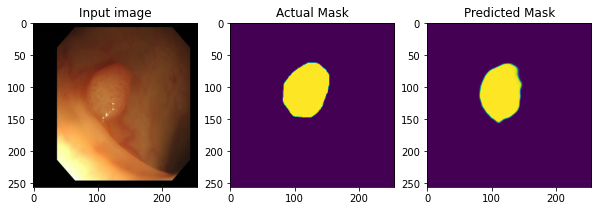

In [39]:
# print sample image after training
print_images()

In [40]:
# Save weight
checkpoint.save(file_prefix = checkpoint_prefix)

'./drive/My Drive/train_ckpt/segmentation/exp1/ckpt-1'

### Plot the loss

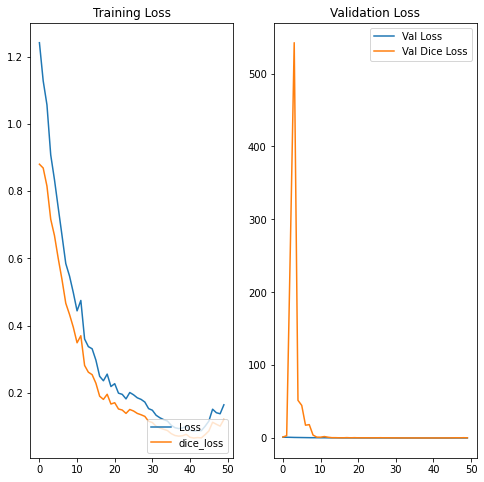

In [41]:
dice_loss = history.history['dice_loss']
loss=history.history['loss']

val_dice_loss = history.history['val_dice_loss']
val_loss=history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='dice_loss')
plt.legend(loc='lower right')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Val Loss')
plt.plot(epochs_range, val_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()


## Restore the latest checkpoint

In [0]:
if not is_train:
    # restoring the latest checkpoint in checkpoint_dir
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Evaluate the test dataset

In [0]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [44]:
#mean = tf.keras.metrics.Mean("mean_iou")
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))
#print("mean_iou: {}".format(mean.result().numpy()))

mean_iou: 0.7960540285803251
